<a href="https://colab.research.google.com/github/TariqAlhathloul/License-Plate-Detection-and-Recognition/blob/main/mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the data

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="mFrUreCV7Y9LdiwgQrx3")
project = rf.workspace("roboflow-universe-projects").project("license-plate-recognition-rxg4e")
version = project.version(1)
dataset = version.download("yolov8")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.8
    Uninstalling idna-3.8:
      Successfully uninstalled idna-3.8
loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to License-Plate-Recognition-1 in yolov8:: 100%|██████████| 20264/20264 [00:02<00:00, 7026.32it/s]


## Import libraries

In [61]:
import numpy as np
import glob
import random
import os

from PIL import Image
import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import Image, display
from IPython import display
display.clear_output()

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [62]:
np.random.seed(93)
tf.random.set_seed(93)

## Images paths

In [3]:
TRAIN_DIR_IAMAGES = '/content/License-Plate-Recognition-1/train/images'
VAL_DIR_IAMGES = '/content/License-Plate-Recognition-1/valid/images'
TEST_DIR_IMAGES = '/content/License-Plate-Recognition-1/test/images'

In [4]:
print(f"Total Training: {len(os.listdir(TRAIN_DIR_IAMAGES))} images")
print(f"Total Validation: {len(os.listdir(VAL_DIR_IAMGES))} images")
print(f"Total Testing: {len(os.listdir(TEST_DIR_IMAGES))} images")

Total Training: 7058 images
Total Validation: 2048 images
Total Testing: 1020 images


## Labels paths

In [5]:
TRAIN_DIR_LABELS = '/content/License-Plate-Recognition-1/train/labels'
VAL_DIR_LABELS = '/content/License-Plate-Recognition-1/valid/labels'
TEST_DIR_LABELS = '/content/License-Plate-Recognition-1/test/labels'

In [6]:
print(f"Total Training: {len(os.listdir(TRAIN_DIR_LABELS))} labels")
print(f"Total Validation: {len(os.listdir(VAL_DIR_LABELS))} labels")
print(f"Total Testing: {len(os.listdir(TEST_DIR_LABELS))} labels")

Total Training: 7058 labels
Total Validation: 2048 labels
Total Testing: 1020 labels


In [7]:
dataset.location

'/content/License-Plate-Recognition-1'

In [8]:
dataset.model_format

'yolov8'

In [9]:
dataset.name

'License Plate Recognition'

In [10]:
dataset.version

'1'

## Preprocessing

## now the data is in YOLOv8 format, c_x, c_y, hight, width we will define a function to convert it to x1, y1, x2, y2. format

In [11]:
def convert_to_bbox(bbox):
  x1_min, y1_min = bbox[0] - bbox[2]/2, bbox[1] - bbox[3]/2
  x2_max, y2_max = bbox[0] + bbox[3]/2, bbox[1] + bbox[3]/2
  return x1_min, y1_min, x2_max, y2_max

# Plotting

## define a function to plot the bounding boxes

In [12]:
def plot_bbox(image, bboxes, labels):

  # hight, width, depth
  h, w, _ = image.shape
  for box_num, box in enumerate(bboxes):
    x1_min, y1_min, x2_max, y2_max = convert_to_bbox(box)
    thickness = max(2, int(w / 22))

    cv2.rectangle(
        image,
        (x1_min, y1_min),
        (x2_max, y2_max),
        color=(255, 0, 0),
        thickness=thickness
    )
    return image

## define a function to plot images with their bounding boxes

In [13]:
def plot_image_bbox(image_path, label_path, samples=5):
    """
    Plot images with their bounding boxes in a grid.
    """
    image_files = os.listdir(image_path)
    label_files = os.listdir(label_path)

    cols = min(samples, 5)
    rows = (samples + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()

    for idx in range(samples):
        img_file = image_files[idx]
        lbl_file = img_file.replace('.jpg', '.txt')

        # Read the image
        img = cv2.imread(os.path.join(image_path, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax = axes[idx]
        ax.imshow(img)

        with open(os.path.join(label_path, lbl_file), 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                class_id, center_x, center_y, width, height = map(float, parts)

                img_h, img_w, _ = img.shape
                center_x = int(center_x * img_w)
                center_y = int(center_y * img_h)
                width = int(width * img_w)
                height = int(height * img_h)

                # calculate the top-left corner of the bounding box
                top_left_x = center_x - width // 2
                top_left_y = center_y - height // 2

                # create a rectangle patch and add it to the plot
                rect = patches.Rectangle((top_left_x, top_left_y), width, height, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

        ax.axis('off')


    for j in range(samples, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


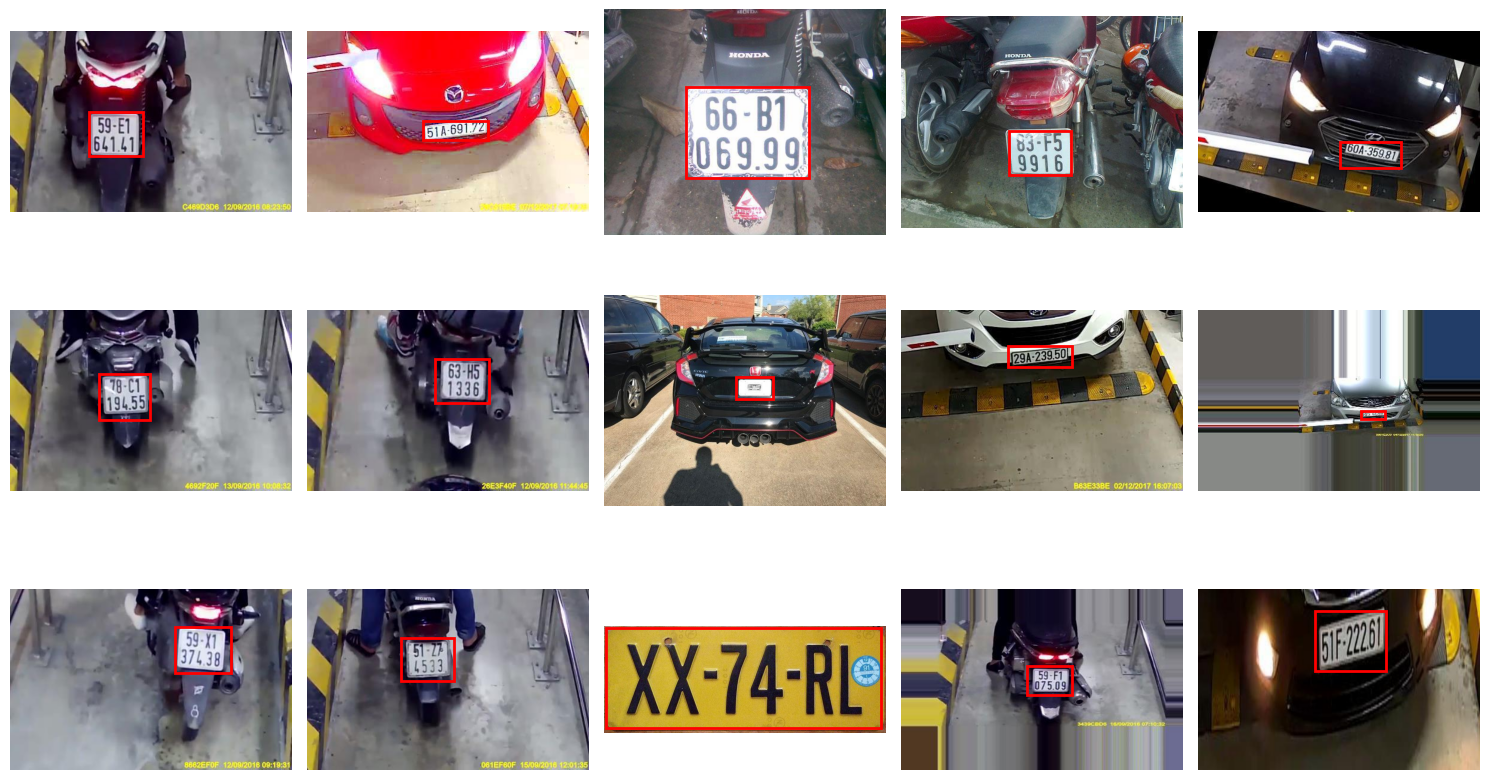

In [14]:
plot_image_bbox(TRAIN_DIR_IAMAGES, TRAIN_DIR_LABELS, samples=15)

------------------------------

## before training the model on our coustom dataset we need to modify the data.yaml file and set the correct paths for traning val and test

In [15]:
#%%writefile License_Plate_YOLOv8n.yaml
"""path: 'License_Plate_YOLOv8n/'
names:
0: 'License_Plate'
nc: 1
roboflow:
  license: CC BY 4.0
  project: license-plate-recognition-rxg4e
  url: https://universe.roboflow.com/roboflow-universe-projects/license-plate-recognition-rxg4e/dataset/1
  version: 1
  workspace: roboflow-universe-projects
test: ../test/images
train: /content/License-Plate-Recognition-1/train/images
val: /content/License-Plate-Recognition-1/valid/images
"""

"path: 'License_Plate_YOLOv8n/'\nnames:\n0: 'License_Plate'\nnc: 1\nroboflow:\n  license: CC BY 4.0\n  project: license-plate-recognition-rxg4e\n  url: https://universe.roboflow.com/roboflow-universe-projects/license-plate-recognition-rxg4e/dataset/1\n  version: 1\n  workspace: roboflow-universe-projects\ntest: ../test/images\ntrain: /content/License-Plate-Recognition-1/train/images\nval: /content/License-Plate-Recognition-1/valid/images\n"

## install pre-trained YOLO model


In [16]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.6/871.6 kB 52.5 MB/s eta 0:00:00


In [17]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Aug 29 13:41:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   36C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [18]:
import tensorflow as tf

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")


GPU is available


### Hyperparameters

In [19]:
IMG_HEIGHT = 640
IMG_WIDTH = 640
IMG_SIZE = 1280
BATCH_SIZE = 32
EPOCHS = 10

## finetuning YOLOv8n

In [23]:
!yolo \
task   = detect \
mode   = train \
model  = yolov8n.pt \
imgsz  = {IMG_SIZE} \
epochs = {EPOCHS} \
batch  = {BATCH_SIZE}\
device = 0 \
verbose = True\
seed = 93 \
plots = True \
val = True \
data   = /content/License-Plate-Recognition-1/data.yaml \
name   = yolov8n_v8_50e


Ultralytics YOLOv8.2.83 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/License-Plate-Recognition-1/data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=1280, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov8n_v8_50e2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=93, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labe

## evaluation on the validation set

In [24]:
!yolo \
task = detect \
mode = val \
model = /content/runs/detect/yolov8n_v8_50e2/weights/best.pt \
data = /content/License-Plate-Recognition-1/data.yaml \
name = yolov8n_evaluate

Ultralytics YOLOv8.2.83 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/License-Plate-Recognition-1/valid/labels.cache... 2048 images, 3 backgrounds, 0 corrupt: 100% 2048/2048 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 128/128 [00:21<00:00,  5.92it/s]
                   all       2048       2134      0.971       0.93       0.98       0.68
Speed: 0.7ms preprocess, 6.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/yolov8n_evaluate
💡 Learn more at https://docs.ultralytics.com/modes/val


## predictions on the test set

In [25]:
!yolo \
task = detect \
mode = predict \
model = /content/runs/detect/yolov8n_v8_50e2/weights/best.pt \
source = /content/License-Plate-Recognition-1/test/images \
imgsz = {IMG_SIZE} \
show_labels = False \
name = YOLOv8n_predictions

Ultralytics YOLOv8.2.83 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

image 1/1020 /content/License-Plate-Recognition-1/test/images/0002a5b67e5f0909_jpg.rf.c8f81ef986e3e99af6f349c200080453.jpg: 960x1280 2 License_Plates, 54.7ms
image 2/1020 /content/License-Plate-Recognition-1/test/images/000812dcf304a8e7_jpg.rf.ba32e6c184b3d974abcced6f7c29af6d.jpg: 1152x1280 1 License_Plate, 55.3ms
image 3/1020 /content/License-Plate-Recognition-1/test/images/0010f4c10f7ab07e_jpg.rf.1844f6dde3b97ed1c762db933bbacaf3.jpg: 960x1280 2 License_Plates, 7.9ms
image 4/1020 /content/License-Plate-Recognition-1/test/images/001cdd25e148cd36_jpg.rf.f6b127a00cc60969152a8a039351ce11.jpg: 960x1280 1 License_Plate, 7.4ms
image 5/1020 /content/License-Plate-Recognition-1/test/images/002519f868563098_jpg.rf.29775b804909c1d042ce008c09f033e4.jpg: 864x1280 1 License_Plate, 55.7ms
image 6/1020 /content/License-Plate-Recognit

## visualization of the training result

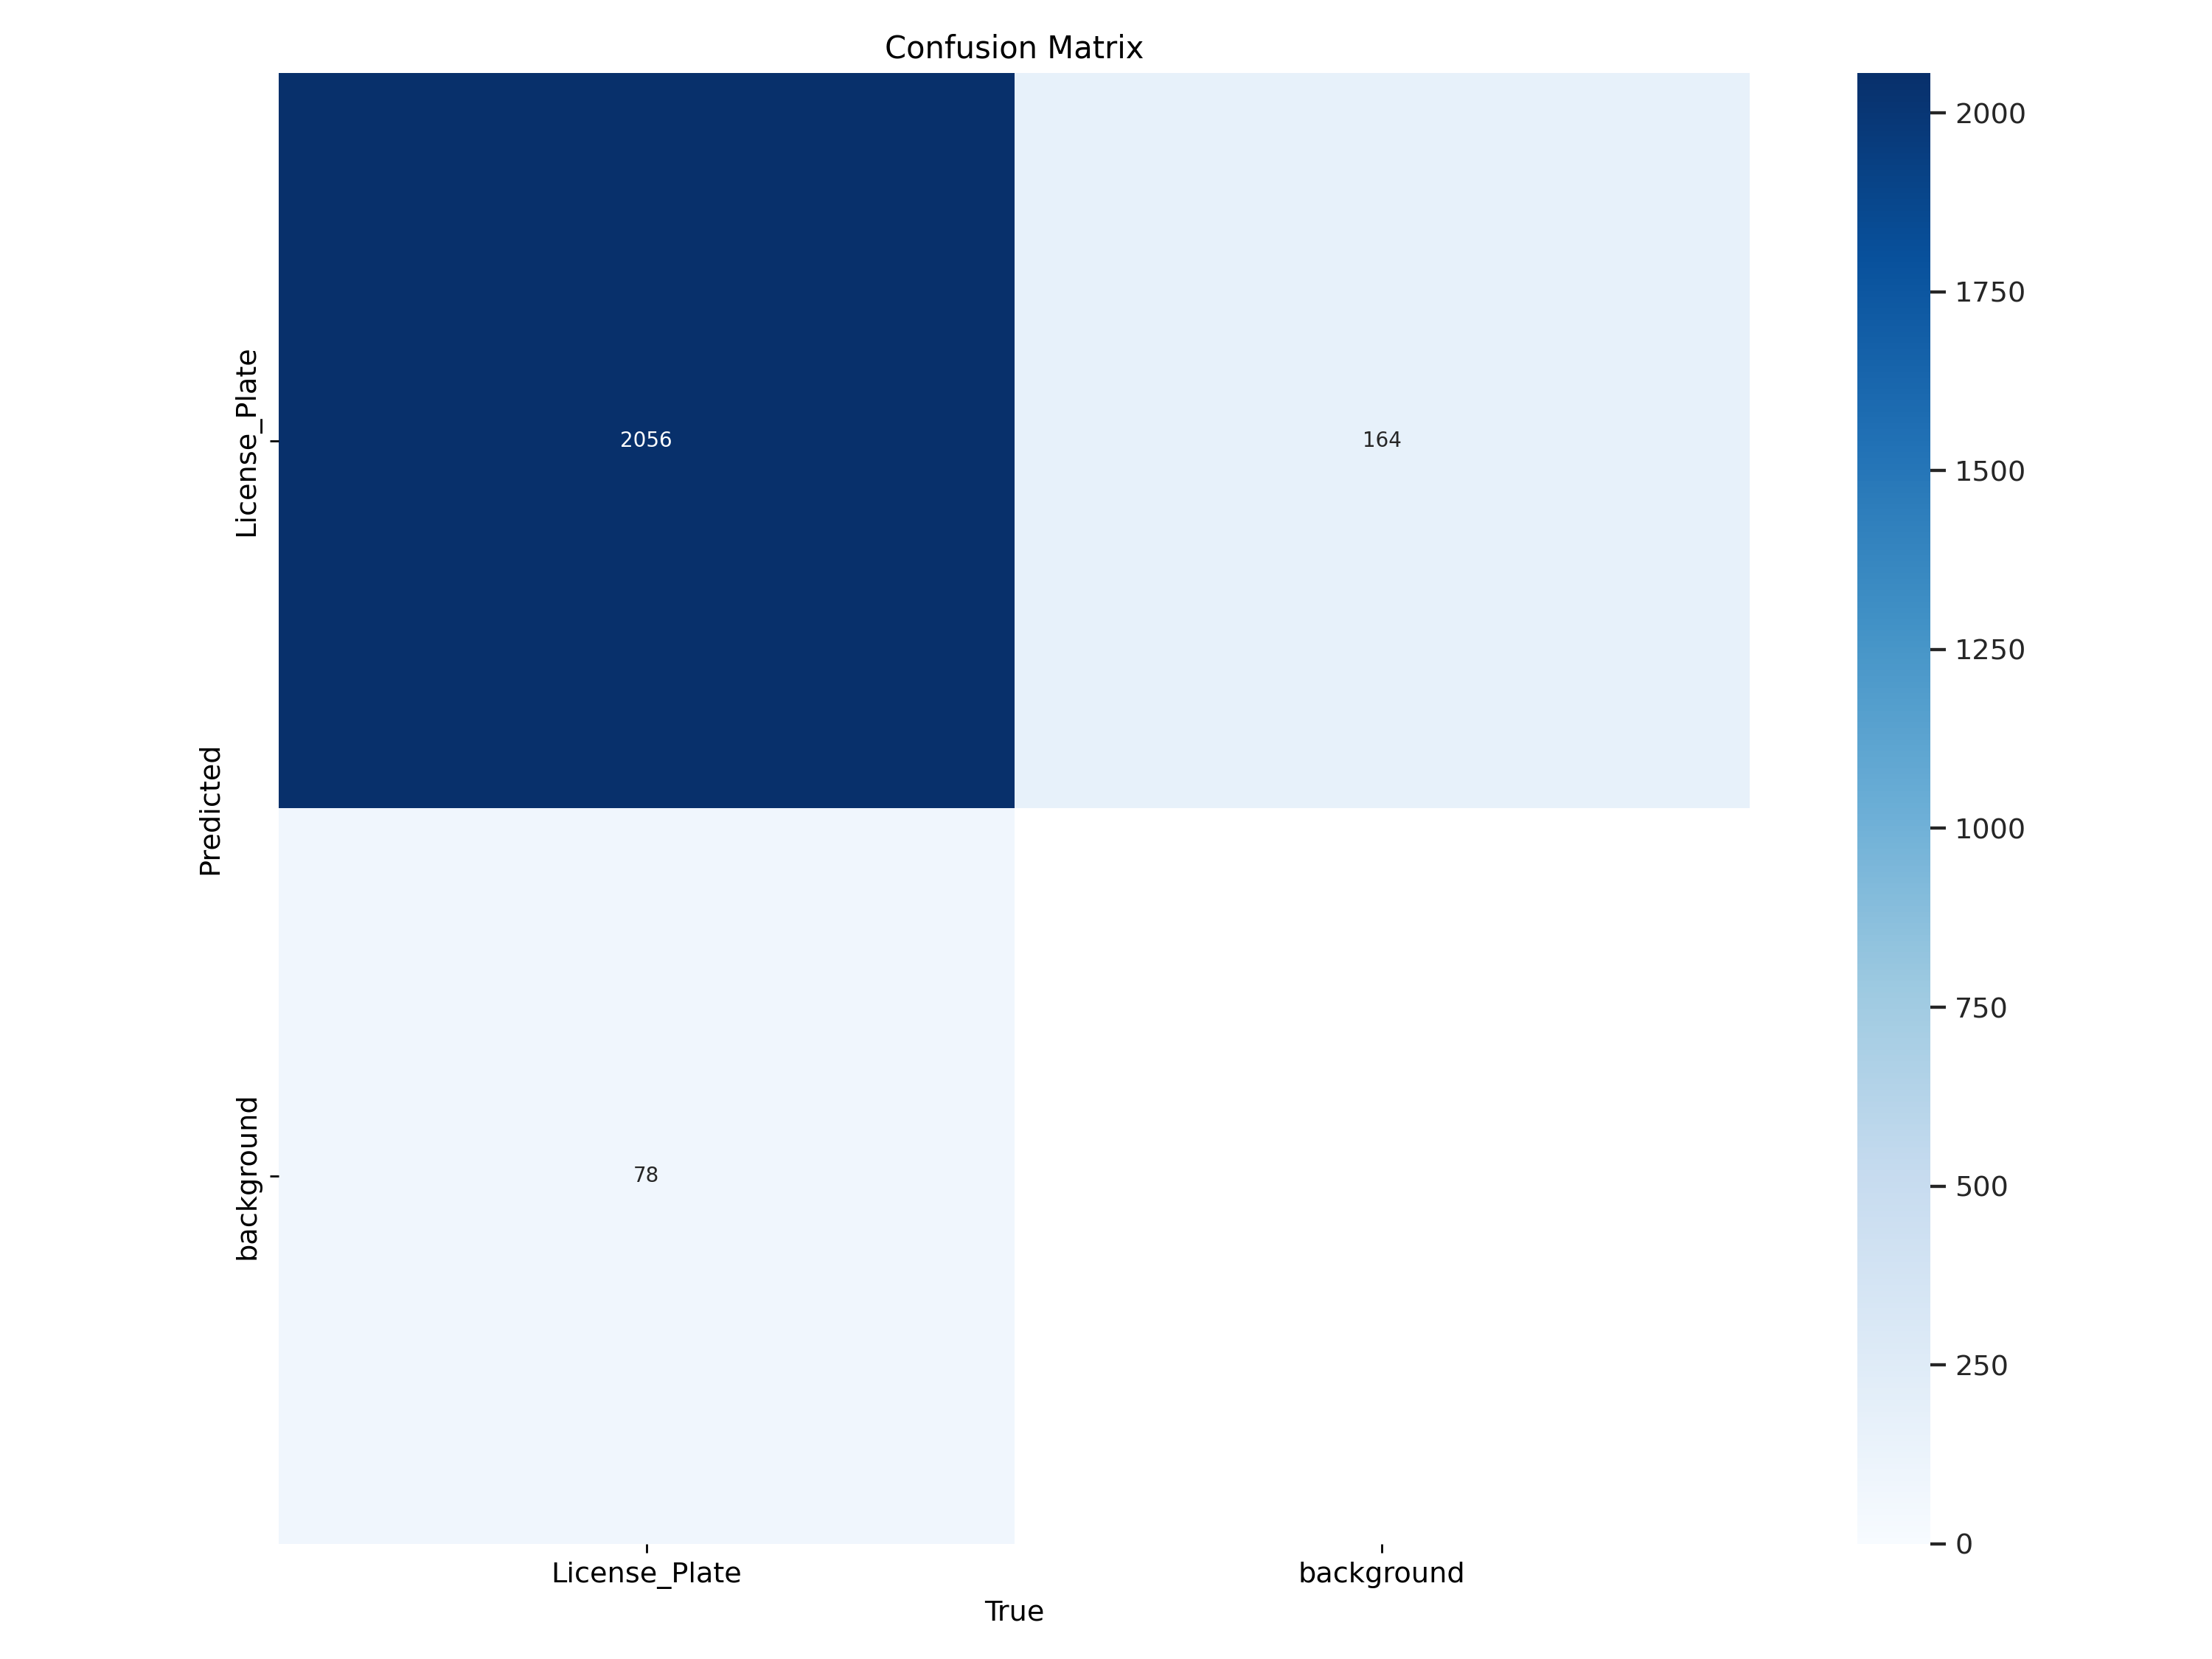

In [26]:
Image(filename='/content/runs/detect/yolov8n_v8_50e2/confusion_matrix.png', width=600)

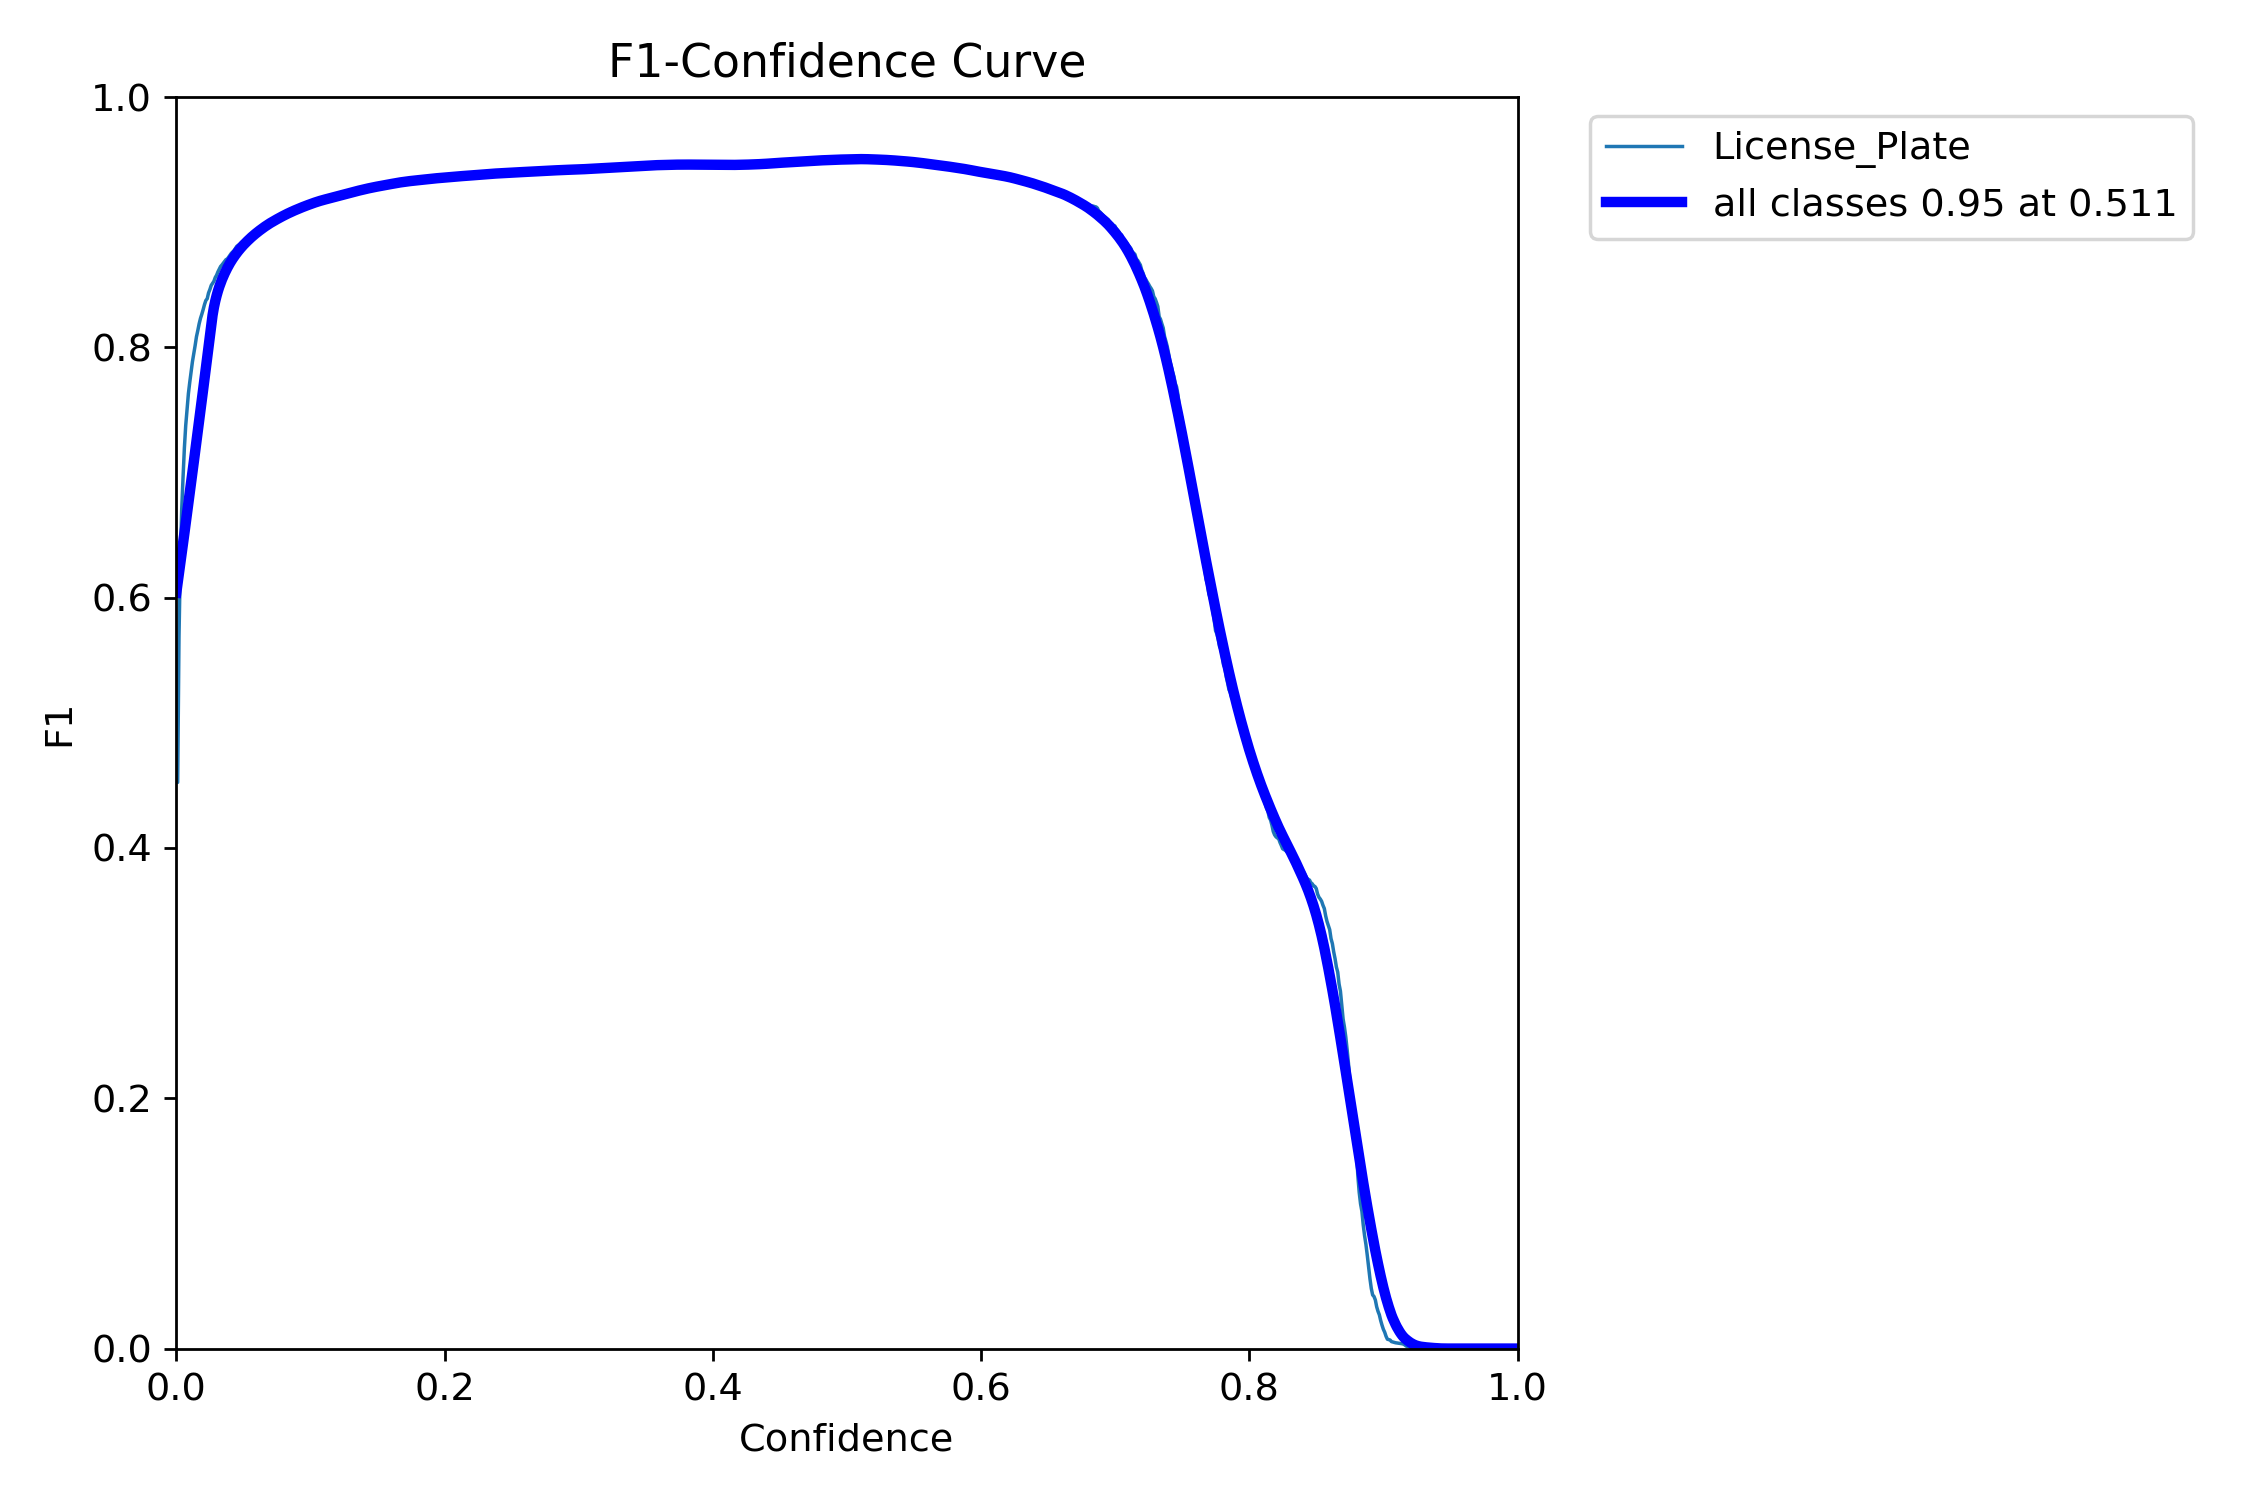

In [29]:
Image(filename='/content/runs/detect/yolov8n_v8_50e2/F1_curve.png', width= 600, height=600)

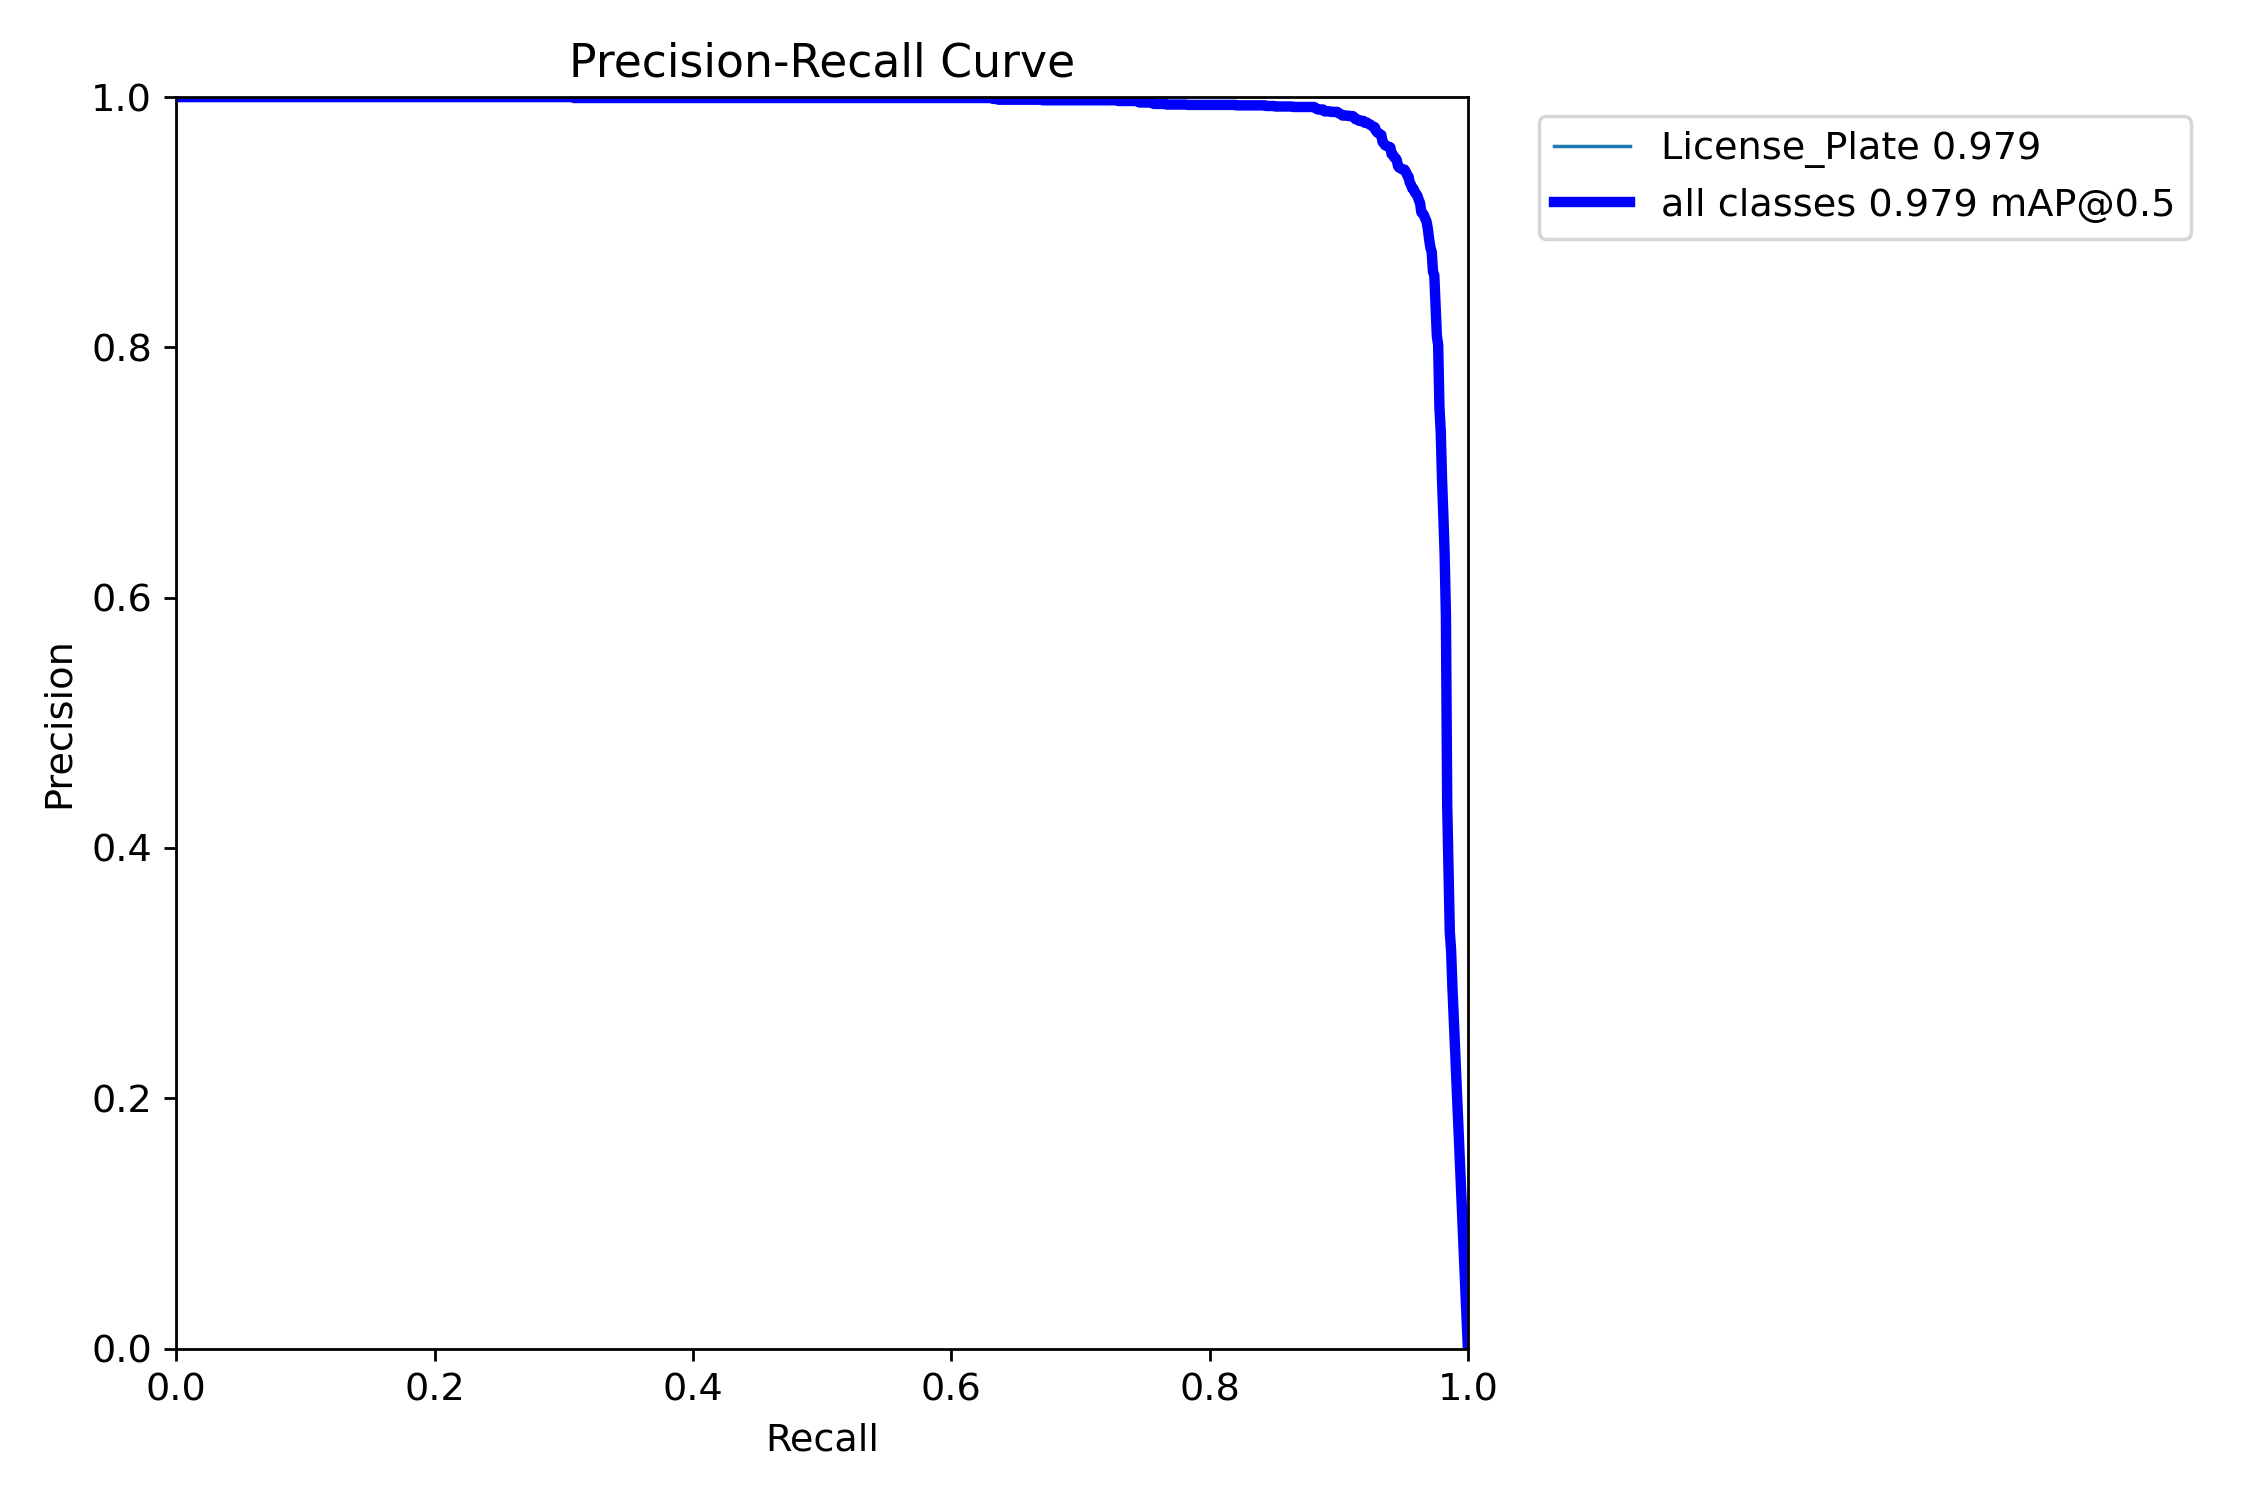

In [30]:
Image(filename='/content/runs/detect/yolov8n_v8_50e2/PR_curve.png', width= 600, height=600)

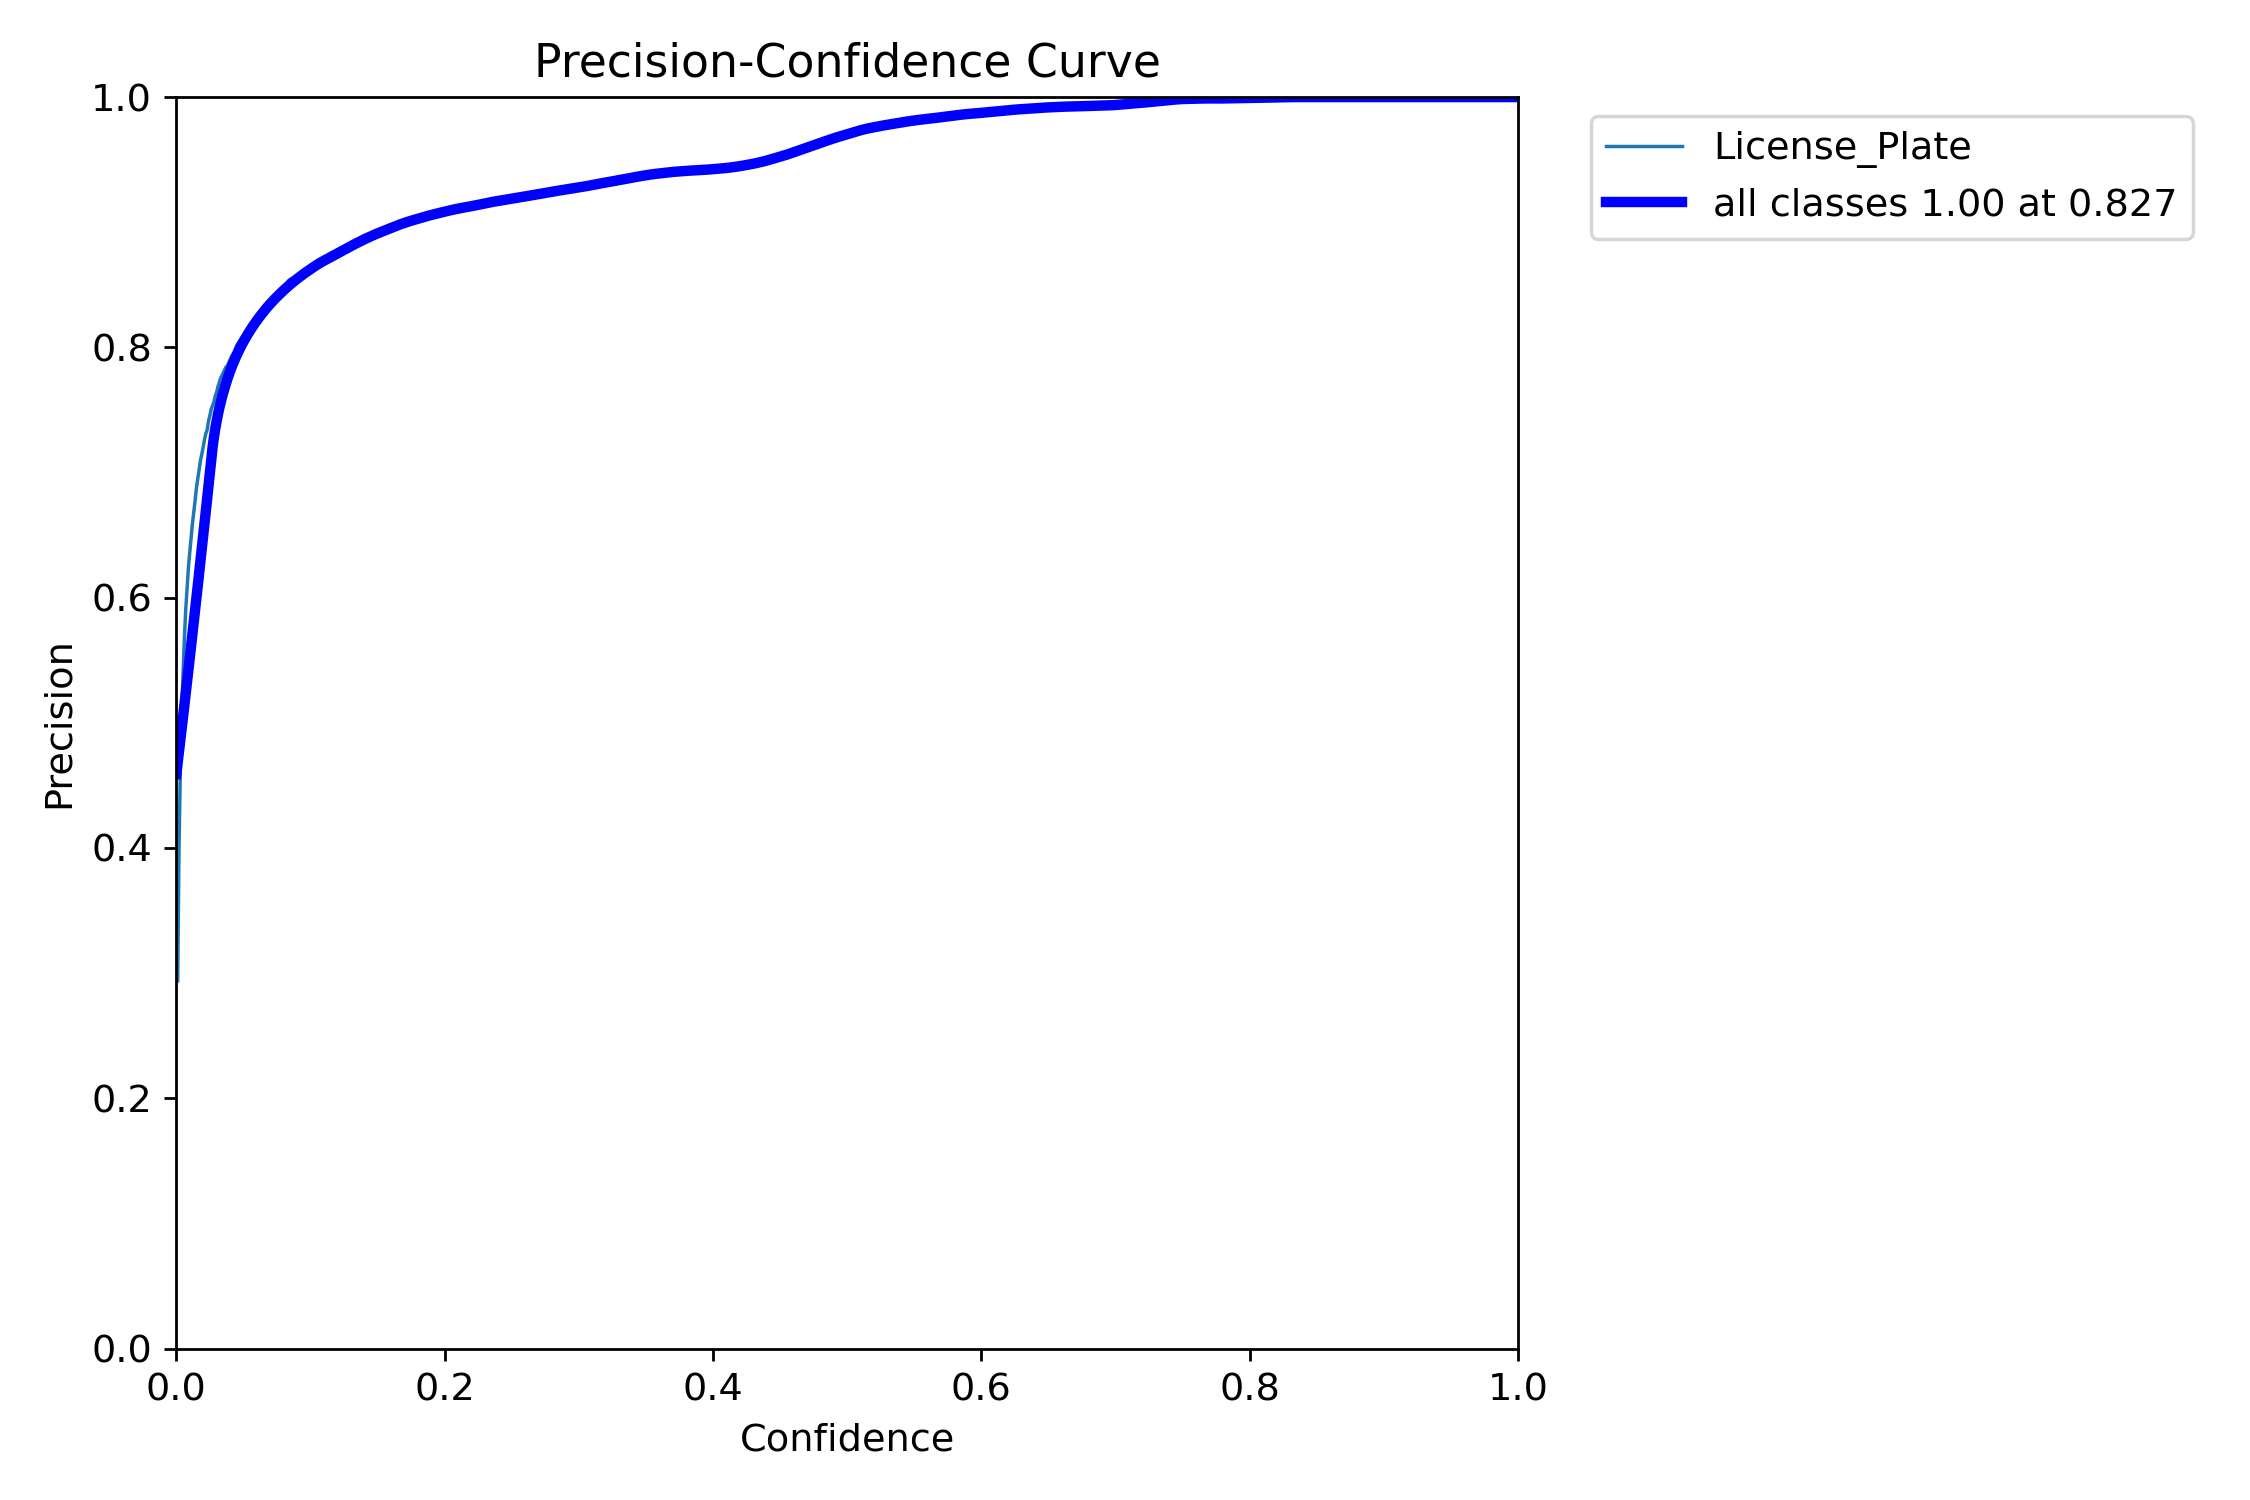

In [31]:
Image(filename='/content/runs/detect/yolov8n_v8_50e2/P_curve.png', width= 600, height=600)

## display the result

In [59]:
def display_result(result_dir, num_samples=5):

  plt.figure(figsize=(20, 15))
  imgs = glob.glob(os.path.join(result_dir, '*.jpg'))
  random.shuffle(imgs)
  for i, img_path in enumerate(imgs):
    img = plt.imread(img_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    if i == num_samples -1:
      break

  plt.show()

ValueError: num must be an integer with 1 <= num <= 4, not 5

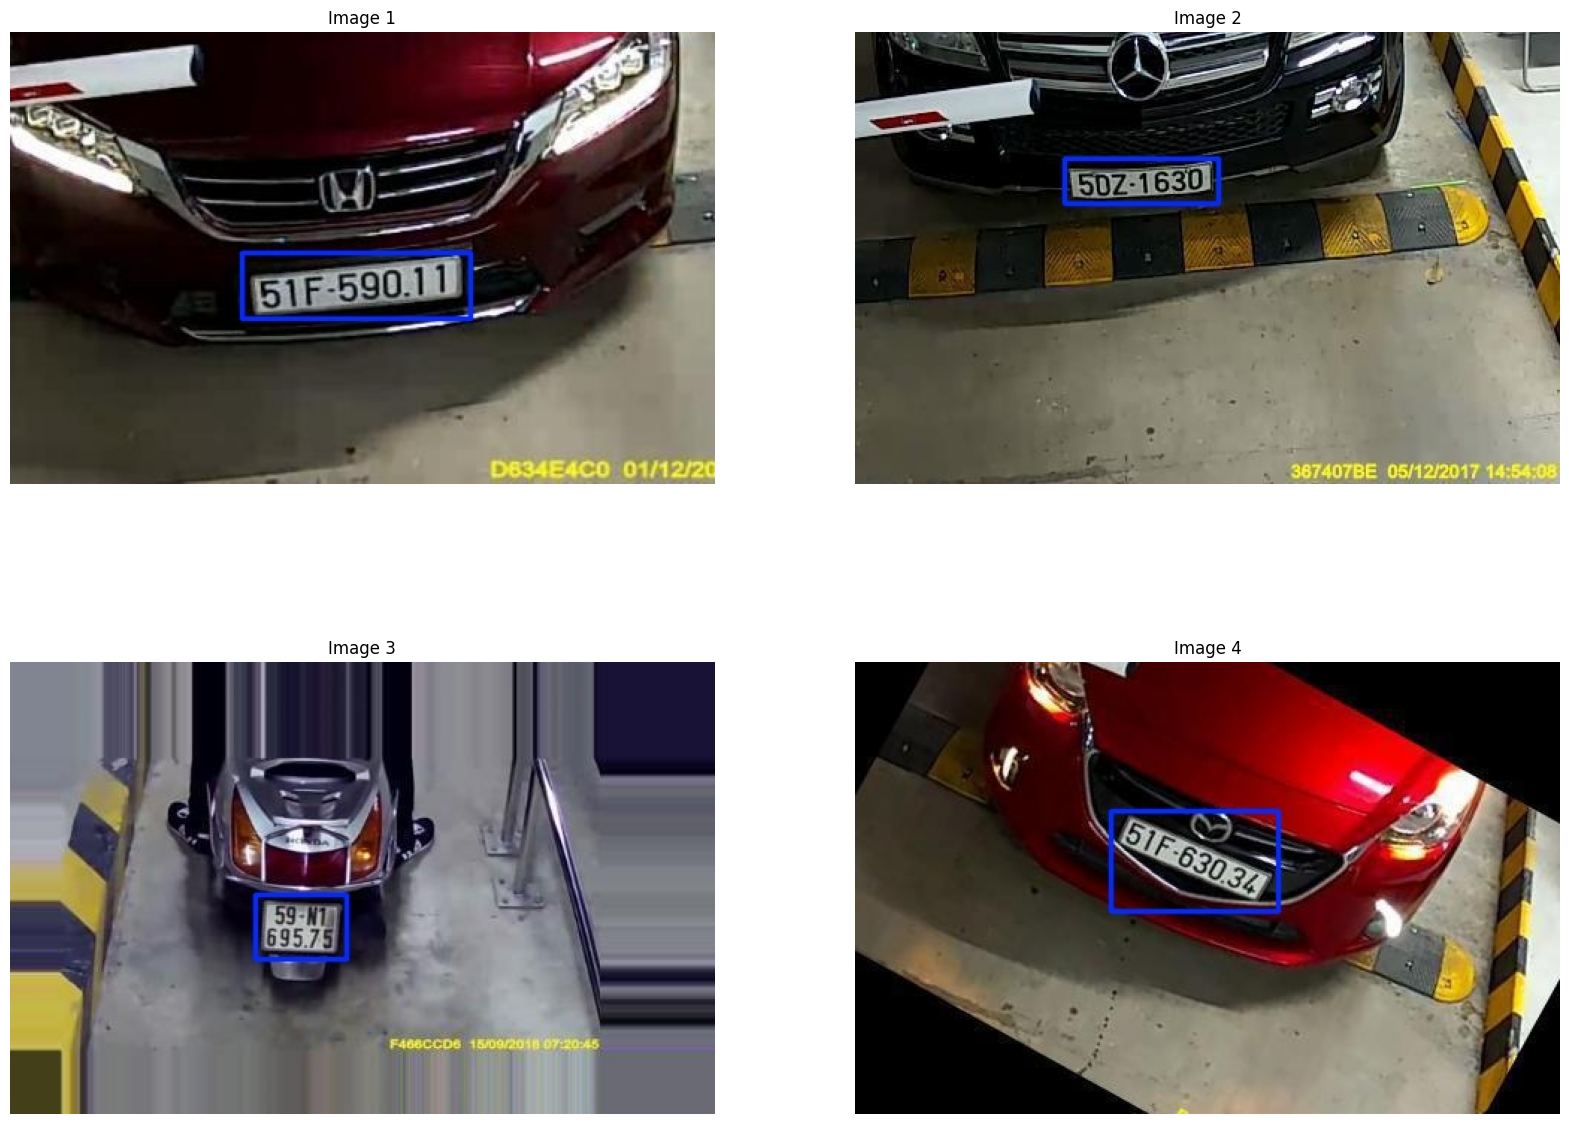

In [63]:
display_result('/content/runs/detect/YOLOv8n_predictions')

## Function to process each image

In [ ]:
def process_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    #image = image / 255.0
    return image


## Function to load the dataset


In [ ]:
def load_dataset(directory):
    file_paths = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    dataset = dataset.map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

## Function to process the label

In [ ]:
def load_labels(label_dir):
    labels = []
    label_files = sorted([os.path.join(label_dir, fname) for fname in os.listdir(label_dir)])

    for label_file in label_files:
        label_content = tf.io.read_file(label_file)
        label_lines = tf.strings.split(label_content, '\n')  # Split lines
        image_labels = []

        for line in label_lines:
            if tf.strings.length(line) > 0:  # Skip empty lines
                parts = tf.strings.split(line, ' ')
                image_labels.append(tf.strings.to_number(parts, out_type=tf.float32))

        labels.append(tf.stack(image_labels))  # Stack the parsed labels for each image

    return labels

# Example usage:
TRAIN_LABEL_DIR = '/content/License-Plate-Recognition-1/train/labels'
labels = load_labels(TRAIN_LABEL_DIR)

## Load the train set


In [ ]:
#train_set = load_dataset(TRAIN_DIR)
train_set = load_dataset(TRAIN_DIR)
train_labels = load_labels('/content/License-Plate-Recognition-1/train/labels')
for batch in train_set.take(1):
    print(batch.shape)

#(BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3)

## Load the validation set

In [ ]:
val_set = load_dataset(VAL_DIR)
val_labels = load_labels('/content/License-Plate-Recognition-1/valid/labels')

## Load the test set

In [ ]:
test_set = load_dataset(TEST_DIR)
test_labels = load_labels('/content/License-Plate-Recognition-1/test/labels')

In [ ]:
!pip install -q keras_cv